# XG Boost Classifier

## 1. Loading the dataset

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

In [3]:
# 1.3. Load the training, validation and test datasets into a dataframes 
# Load the Parquet files into DataFrames
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_val = pd.read_parquet('../data/processed/X_val.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_val = pd.read_parquet('../data/processed/y_val.parquet')
X_test = pd.read_parquet('../data/processed/X_test_scaled.parquet')

In [4]:
# taking out the player id out of the test data
player_id_test = X_test.pop('player_id')

In [5]:
y_val = y_val.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_val.shape

(9324,)

In [6]:
y_train = y_train.iloc[:, 0]  # Convert the single column DataFrame to a Series
y_train.shape

(37294,)

## 3. XGBoost - Modelling

In [7]:
#3.1 Import XGBoost and instantiate the model
import xgboost as xgb

# Initialize the GB model
xg1 = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

In [8]:
# 3.2 Train the model and save the predicted values
# Fit the model on the training data
xg1.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
# Select the probability for the positive class (class 1) - GB with out feature importance
y_train_probs_xg1 = xg1.predict_proba(X_train)[:, 1]
y_val_probs_xg1 = xg1.predict_proba(X_val)[:, 1]


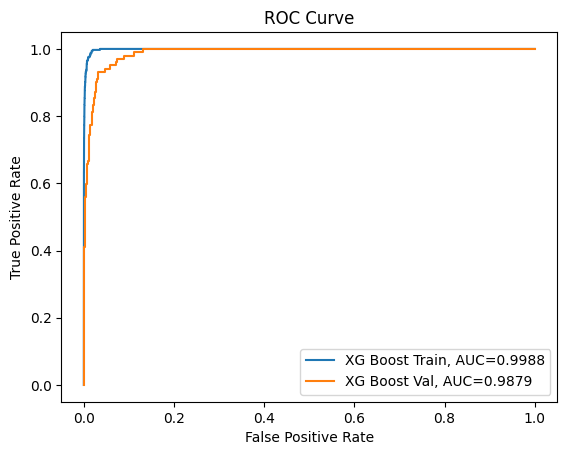

In [10]:
# 3.3 To plot ROC curve and the AUC metric - for comparison of model performances
#To plot ROC curve and the AUC metric
from sklearn import metrics

# Set up plotting area
plt.figure(0).clf()

# XG Boost- Train
fpr, tpr, _ = metrics.roc_curve(y_train, y_train_probs_xg1)
auc = round(metrics.roc_auc_score(y_train, y_train_probs_xg1), 4)
plt.plot(fpr, tpr, label="XG Boost Train, AUC="+str(auc))

# XG Boost - Validation
fpr, tpr, _ = metrics.roc_curve(y_val, y_val_probs_xg1)
auc = round(metrics.roc_auc_score(y_val, y_val_probs_xg1), 4)
plt.plot(fpr, tpr, label="XG Boost Val, AUC="+str(auc))

# Add legend
plt.legend()

# Show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [11]:
# 3.4 Save the probability of the test data
y_test_probs_xg1 = xg1.predict_proba(X_test)[:, 1]


In [12]:
# 3.5 add the 'player_id'column  into the prediction probability
# Convert y_test_prob_rf3 (which is a NumPy array) to a DataFrame
y_test_probs_df = pd.DataFrame(y_test_probs_xg1, columns=['drafted'])

# Concatenate player_id_test and y_test_prob_df along the columns
Results = pd.concat([player_id_test, y_test_probs_df], axis=1)

In [13]:
Results

,player_id,drafted
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,0.000018
1,52a518bb-b34a-4b43-adee-5e996cb853fa,0.000047
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,0.000138
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,0.000030
4,55d07491-5bd1-447f-844e-9cb36eaa442e,0.000834
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,0.000440
4966,c32a466d-7a66-47eb-805c-a94e328261bc,0.000023
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,0.000019
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,0.000019


In [14]:
#3.6 save the probability as CSV file

# Convert to DataFrame and save
pd.DataFrame(Results).to_csv('../data/external/XGBoost_Results.csv', index=False)

#3.7 save the model
# Import dump from joblib
from joblib import dump

# 3.12 Save the model and call the files respectively GB.joblib 
dump(xg1, '../models/XGBoost.joblib')


['../models/XGBoost.joblib']